In [1]:
import os
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt


In [2]:
spark = SparkSession.builder \
    .appName("WeatherModelTraining") \
    .config("spark.driver.memory", "2g") \
    .master("local[*]") \
    .getOrCreate()

25/04/09 15:47:38 WARN Utils: Your hostname, Agnibhas-MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 192.168.1.85 instead (on interface en0)
25/04/09 15:47:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/09 15:47:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [48]:
data_path="../../data/processed/weather_data.parquet"
spark_df = spark.read.parquet(data_path)
df = spark_df.toPandas()
# df_all
df[(df['data_type'] == 'current') | (df['data_type'] == 'historical')]
df

,city,country,data_type,timestamp,temp,feels_like,temp_min,temp_max,pressure,humidity,...,wind_deg,clouds,weather_main,weather_description,date,hour,day,month,year,dew_point
0,london,uk,historical,2025-04-08 15:00:00,15.50,14.23,14.95,16.12,1026,43,...,85,100,Clouds,overcast clouds,2025-04-08 15:00:00,15,8,4,2025,4.10
1,london,uk,historical,2025-04-07 15:00:00,15.27,13.87,13.33,16.11,1025,39,...,118,6,Clear,clear sky,2025-04-07 15:00:00,15,7,4,2025,3.07
2,london,uk,historical,2025-04-06 15:00:00,14.99,13.46,12.86,16.10,1023,35,...,80,62,Clouds,broken clouds,2025-04-06 15:00:00,15,6,4,2025,1.99
3,london,uk,historical,2025-04-05 15:00:00,17.60,16.38,15.86,18.88,1020,37,...,70,1,Clear,clear sky,2025-04-05 15:00:00,15,5,4,2025,5.00
4,tokyo,jp,current,2025-04-09 14:39:02,14.00,13.13,13.12,14.24,1015,64,...,120,75,Clouds,broken clouds,2025-04-09 14:39:02,14,9,4,2025,6.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,new york,us,forecast,2025-04-14 09:00:00,6.41,3.21,6.41,6.41,1013,78,...,304,11,Clouds,few clouds,2025-04-14 09:00:00,9,14,4,2025,2.01
221,new york,us,forecast,2025-04-14 12:00:00,7.01,4.23,7.01,7.01,1013,73,...,322,51,Clouds,broken clouds,2025-04-14 12:00:00,12,14,4,2025,1.61
222,sydney,au,historical,2025-04-08 15:00:00,17.03,17.11,16.33,17.61,1024,89,...,320,100,Clouds,overcast clouds,2025-04-08 15:00:00,15,8,4,2025,14.83
223,sydney,au,historical,2025-04-07 15:00:00,18.21,18.10,16.28,18.73,1021,77,...,120,100,Rain,light intensity shower rain,2025-04-07 15:00:00,15,7,4,2025,13.61


In [23]:
df_all = df_all.sort_values(by=['city', 'timestamp'])


df_now = df_all[df_all['data_type'].isin(['historical', 'current'])]
df_fut = df_all[df_all['data_type'] == 'forecast']

df_now['next_day_temp'] = df_now.groupby('city')['temp'].shift(-1)
df_now = df_now.dropna(subset=['next_day_temp'])
df_now

/var/folders/mz/s_r2vvzs48b342530t9_3smh0000gn/T/ipykernel_21774/928944138.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_now['next_day_temp'] = df_now.groupby('city')['temp'].shift(-1)


,city,country,data_type,timestamp,temp,feels_like,temp_min,temp_max,pressure,humidity,...,clouds,weather_main,weather_description,date,hour,day,month,year,dew_point,next_day_temp
8,kolkata,in,historical,2025-04-05 15:00:00,30.97,34.30,30.97,30.97,1007,58,...,0,Haze,haze,2025-04-05 15:00:00,15,5,4,2025,22.57,28.97
7,kolkata,in,historical,2025-04-06 15:00:00,28.97,35.55,28.97,28.97,1008,84,...,20,Haze,haze,2025-04-06 15:00:00,15,6,4,2025,25.77,28.97
6,kolkata,in,historical,2025-04-07 15:00:00,28.97,33.42,28.97,28.97,1011,74,...,0,Haze,haze,2025-04-07 15:00:00,15,7,4,2025,23.77,28.97
5,kolkata,in,historical,2025-04-08 15:00:00,28.97,32.66,28.97,28.97,1013,70,...,20,Haze,haze,2025-04-08 15:00:00,15,8,4,2025,22.97,29.97
3,london,uk,historical,2025-04-05 15:00:00,17.60,16.38,15.86,18.88,1020,37,...,1,Clear,clear sky,2025-04-05 15:00:00,15,5,4,2025,5.00,14.99
2,london,uk,historical,2025-04-06 15:00:00,14.99,13.46,12.86,16.10,1023,35,...,62,Clouds,broken clouds,2025-04-06 15:00:00,15,6,4,2025,1.99,15.27
1,london,uk,historical,2025-04-07 15:00:00,15.27,13.87,13.33,16.11,1025,39,...,6,Clear,clear sky,2025-04-07 15:00:00,15,7,4,2025,3.07,15.50
0,london,uk,historical,2025-04-08 15:00:00,15.50,14.23,14.95,16.12,1026,43,...,100,Clouds,overcast clouds,2025-04-08 15:00:00,15,8,4,2025,4.10,13.43
157,new york,us,historical,2025-04-05 15:00:00,10.80,9.50,9.42,11.86,1024,60,...,100,Clouds,overcast clouds,2025-04-05 15:00:00,15,5,4,2025,2.80,8.97
156,new york,us,historical,2025-04-06 15:00:00,8.97,6.52,7.87,10.00,1011,91,...,100,Rain,light rain,2025-04-06 15:00:00,15,6,4,2025,7.17,5.33


In [24]:
feature_cols = [
    'temp', 'feels_like', 'humidity', 'pressure', 
    'wind_speed', 'clouds', 'hour', 'day', 'month'
]

# Categorical features
cat_cols = ['weather_main', 'city', 'country']

# Target
target_col = 'next_day_temp'

In [31]:
# Split features and target
X = df_now[feature_cols + cat_cols]
y = df_now[target_col]

# # Create train-test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# Use all values from df_now as train and all from df_fut as test
X_train = df_now[feature_cols + cat_cols]
y_train = df_now[target_col]

X_test = df_fut[feature_cols + cat_cols]
y_test = df_fut['temp']

# print(f'XTrain {X_train}')
print(f'YTrain {y_train}')

YTrain 8      28.97
7      28.97
6      28.97
5      29.97
3      14.99
2      15.27
1      15.50
0      13.43
157     8.97
156     5.33
155     4.85
154     3.12
84     16.47
224    18.21
223    17.03
222    17.09
12     14.28
11     11.82
10     14.90
9      14.00
Name: next_day_temp, dtype: float64


In [32]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, feature_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [33]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [44]:
lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)

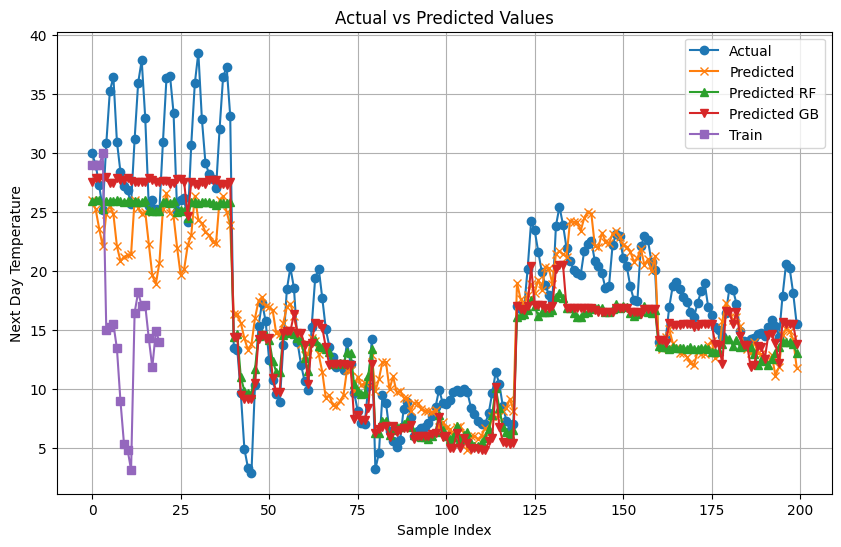

In [45]:

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(y_pred, label="Predicted", marker='x')
plt.plot(y_pred_rf, label="Predicted RF", marker='^')
plt.plot(y_pred_gb, label="Predicted GB", marker='v')
plt.plot(y_train.values, label="Train", marker='s')
plt.title("Actual vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Next Day Temperature")
plt.legend()
plt.grid()
plt.show()

In [ ]:

    def train_and_evaluate(self, pipelines, X_train, X_test, y_train, y_test):
        """Train models and evaluate their performance."""
        results = {}
        
        for name, pipeline in pipelines.items():
            print(f"Training {name} model...")
            
            # Define parameter grid for grid search
            if name == 'random_forest':
                param_grid = {
                    'model__n_estimators': [50, 100],
                    'model__max_depth': [None, 10, 20]
                }
            elif name == 'gradient_boosting':
                param_grid = {
                    'model__n_estimators': [50, 100],
                    'model__learning_rate': [0.01, 0.1]
                }
            else:  # linear regression
                param_grid = {}
            
            # Use grid search if param_grid is not empty
            if param_grid:
                grid_search = GridSearchCV(
                    pipeline, param_grid, cv=3, n_jobs=-1, 
                    scoring='neg_mean_squared_error'
                )
                grid_search.fit(X_train, y_train)
                pipeline = grid_search.best_estimator_
                best_params = grid_search.best_params_
            else:
                pipeline.fit(X_train, y_train)
                best_params = {}
            
            # Make predictions
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            # Store results
            results[name] = {
                'pipeline': pipeline,
                'best_params': best_params,
                'mse': mse,
                'rmse': rmse,
                'mae': mae,
                'r2': r2
            }
            
            print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        
        return results
    
    def save_best_model(self, results):
        """Save the best performing model."""
        # Find best model based on RMSE
        best_model_name = min(results, key=lambda x: results[x]['rmse'])
        best_model = results[best_model_name]['pipeline']
        
        # Save the model
        model_path = "models/weather_prediction_model.joblib"
        joblib.dump(best_model, model_path)
        
        # Save model info
        model_info = {
            'model_name': best_model_name,
            'metrics': {
                'rmse': results[best_model_name]['rmse'],
                'mae': results[best_model_name]['mae'],
                'r2': results[best_model_name]['r2']
            },
            'best_params': results[best_model_name]['best_params']
        }
        
        # Save model info as JSON
        import json
        with open("models/model_info.json", "w") as f:
            json.dump(model_info, f, indent=4)
        
        print(f"Best model ({best_model_name}) saved to {model_path}")
        return model_path, model_info
    
    def train_model(self):
        """Train weather prediction model."""
        # Load data
        print("Loading data...")
        df = self.load_data()
        
        # Prepare features
        print("Preparing features...")
        X_train, X_test, y_train, y_test, feature_cols, cat_cols = self.prepare_features(df)
        
        # Build model pipelines
        print("Building model pipelines...")
        pipelines = self.build_model_pipeline(feature_cols, cat_cols)
        
        # Train and evaluate models
        print("Training and evaluating models...")
        results = self.train_and_evaluate(pipelines, X_train, X_test, y_train, y_test)
        
        # Save best model
        print("Saving best model...")
        model_path, model_info = self.save_best_model(results)
        
        return model_path, model_info

if __name__ == "__main__":
    trainer = WeatherModelTrainer()
    trainer.train_model()